## Import thư viện

In [2]:
from google.colab import files    # upload file từ máy lên Colab

# Nhóm thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt   # vẽ biểu đồ cơ bản
import seaborn as sns             # vẽ biểu đồ mở rộng, hỗ trợ vẽ biểu đồ tương tác
import pandas as pd               # xử lý dữ liệu dạng bảng, hỗ trợ DataFrame tiện cho phân tích
import string                     # xử lý chuỗi
import re                         # xử lý chuỗi bằng Regular Expression để làm sạch và trích xuất dữ liệu

# nhóm thư viện sklearn
from sklearn.linear_model import LogisticRegression               # mô hình phân loại (Logistic Regression)
from sklearn.model_selection import train_test_split              # chia dữ liệu train/test
from sklearn.feature_extraction.text import TfidfVectorizer       # biến text thành vector số (TF-IDF)
from sklearn.metrics import (
    accuracy_score,               # độ chính xác %
    classification_report,        # báo cáo precision, recall, f1-score
    confusion_matrix,             # ma trận nhầm lẫn
    ConfusionMatrixDisplay        # vẽ trực quan confusion matrix
)

# Nhóm thư viện tải model
import joblib

## Upload dữ liệu

### Tải dữ liệu từ máy

In [3]:
# upload file dữ liệu từ máy tính lên Colab
uploaded = files.upload()

Saving email.csv to email.csv


### Đọc dữ liệu

In [ ]:
# Đọc dữ liệu CSV

In [4]:
FILE_NAME = "email.csv"
df = pd.read_csv(FILE_NAME)

df = df.drop_duplicates()     # xóa các câu trùng lặp
print(f"Kích thước dataset: {df.shape} \n")

print("5 dòng đầu:")
display(df.head())

print("\n Kiểm tra phân bố nhãn")
print(df['Category'].value_counts())

Kích thước dataset: (5158, 2) 

5 dòng đầu:


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



 Kiểm tra phân bố nhãn
Category
ham               4516
spam               641
{"mode":"full"       1
Name: count, dtype: int64


## Tiền xử lý dữ liệu

### Làm sạch và chuẩn hóa dữ liệu

In [5]:
# Tiền xử lý văn bản

def clean_text(text):
  text = text.lower()                                     # "Free Money" -> "free money"
  text = re.sub(f"[{string.punctuation}]", "", text)      # Xóa dấu câu: "Hello!!! Free?? Money." -> "Hello Free Money"
  text = re.sub(r"\d+", "", text)                         # Xóa số: "Win 1000 dollars now" -> "Win dollars now"
  return text

df['Message'] = df['Message'].apply(clean_text)

### Mã hóa nhãn

In [6]:
df = df[df["Category"].isin(['ham', 'spam'])] # chỉ lấy mẫu có nhãn là 'ham' hoặc 'spam'
X = df["Message"]
y = df['Category']

print("Kiểm tra phân bố nhãn:")
print(y.value_counts())

print("\nKiểm tra phân bố nhãn (theo tỉ lệ):")
print(y.value_counts() / len(y))

y = y.map({
    'ham': 0,
    'spam': 1
}) # chuyển nhãn chữ thành số



Kiểm tra phân bố nhãn:
Category
ham     4516
spam     641
Name: count, dtype: int64

 Kiểm tra phân bố nhãn (theo tỉ lệ):
Category
ham     0.875703
spam    0.124297
Name: count, dtype: float64


### Đánh giá sơ : Dataset đang bị mất cân bằng, số nhãn ham đang nhiều hơn spam gấp 7 lần

## Xử lý dữ liệu

### Chia tập train/test

In [8]:
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,     # chia tập test 20%
    stratify = y,        # tỉ lệ nhãn trên tập test sẽ giống vỏi tập train
    random_state = 42    # dùng để tái lập kết quả
)

print("Đã chia tập train/test với tỉ lệ 80/20")

Đã chia tập train/test


### TF-IDF Vectorizer

In [9]:
# chuyển đổi văn bản thành vector số
vectorizer = TfidfVectorizer()

# B1: huấn luyện vectorizer với dữ liệu huấn luyện
vectorizer.fit(X_train)

# Giả sử vectorizer là đối tượng TdidfVectorizer đã huấn luyện
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# B2: Chuyển đổi dữ liệu huấn luyện thành vector số
X_train_tfidf = vectorizer.transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)


## Huấn luyện mô hình


In [10]:
model = LogisticRegression(
    class_weight = "balanced"  # xử lý các bộ dữ liệu mất cân bằng
    """
    Ý nghĩa: Mô hình sẽ tự động tính toán trọng số (weights) cho mỗi lớp dựa trên
    tần suất xuất hiện của chúng trong tập train
    Mục đích: Đảm bảo rằng mô hình không bị thiên vị (biased) quá mức
    về phía lớp chiếm đa số
    Cơ chế: Mô hình gán trọng số cao hơn cho các mẫu thuộc lớp thiểu số
    và trọng số thấp hơn cho các mẫu thuộc lớp đa số.
    Tác dụng:
      - Trong quá trình train, khi mô hình mắc lỗi trên một mẫu thuộc
      thiểu số, loss sẽ lớn hơn so với mắc lỗi trên mẫu đa số.
      - Mô hình phải chú ý hơn việc phân loại đúng các mẫu thuộc
      thiểu số để giảm thiểu loss.
    """
)

model.fit(X_train_tfidf, y_train)

print("Đã huấn luyện mô hình")

Đã huấn luyện mô hình


## Đánh giá mô hình

=== Logistic Regression (train/test 80%/20%) ===
Accuracy: 0.9641472868217055
----------------------------------------------------------------------------------------------------
Confusion Matrix:


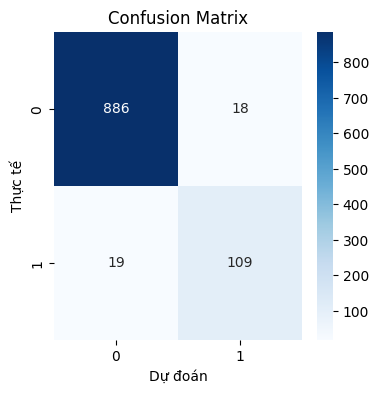

----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       904
           1       0.86      0.85      0.85       128

    accuracy                           0.96      1032
   macro avg       0.92      0.92      0.92      1032
weighted avg       0.96      0.96      0.96      1032



In [11]:
# Dự đoán nhãn trên tập test
y_pred = model.predict(X_test_tfidf)

# Tính độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"=== Logistic Regression (train/test 80%/20%) ===")
print(f"Accuracy: {acc}")
print('-'*100)

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,  # in giá trị trong mỗi ô
    fmt='d',     # định dạng số nguyên
    cmap='Blues' # màu xanh
)
plt.title("Confusion Matrix")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()
print("-"*100)

# Báo cáo chi tiết các chỉ số: precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))
#

## Giao diện

### Lưu mô hình

In [12]:
# Lưu mô hình đã huấn luyện
joblib.dump(model, "phanloaiemail.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Mô hình đã được lưu")

Mô hình đã được lưu


### Tải thư viện để Deploy

In [13]:
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.6 MB/s eta 0:00:00


### Viết giao diện

In [14]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===== Load model =====
model = joblib.load("phanloaiemail.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# ===== Page Config =====
st.set_page_config(
    page_title="Spam Email Classifier Pro",
    page_icon="🚨",
    layout="wide"
)

# ===== Card Component =====
def card(title, desc, link=None, icon="📌"):
    st.markdown(
        f"""
        <div style="
            padding:1rem;
            border-radius:12px;
            background:#e5e5e5;
            margin-bottom:1rem;
            box-shadow:0 2px 6px rgba(0,0,0,0.08);
        ">
            <h3 style="margin:0;">{icon} {title}</h3>
            <p style="margin:0.2rem 0 0.6rem 0; color:#444;">{desc}</p>
            {f'<a href="{link}" target="_blank" style="text-decoration:none; color:#0066cc; font-weight:600;">👉 Visit</a>' if link else ""}
        </div>
        """,
        unsafe_allow_html=True
    )
# col_, col_t, col__ = st.columns([2,4,1])
# with col_t:
#     st.title("🚨 Spam Email Classifier")

st.markdown("<h1 style='text-align:center;'>🚨 Spam Email Classifier</h1>", unsafe_allow_html=True)


# ===== Tabs =====
tab1, tab2, tab3 = st.tabs(["🏠 Dashboard", "📝 Test Email", "📂 Batch Upload"])

# ===== Dashboard =====
with tab1:
    st.info("Ứng dụng này phân loại Spam/Ham với Logistic Regression + TF-IDF.")

    col1, col2, col3 = st.columns(3)
    with col1:
        card("Model", "Logistic Regression", icon="🤖")
    with col2:
        card("Vectorizer", "TF-IDF", icon="📊")
    with col3:
        card("Accuracy", "≈ 96%+", icon="✅")

    # Example mini chart
    with st.expander("📈 Ví dụ phân bố Spam/Ham"):
        sample = pd.DataFrame({"Type": ["Spam", "Ham"], "Count": [60, 40]})
        col_A, col_B, col_C = st.columns([1,2,1])
        with col_B:
            fig_d, ax_d = plt.subplots()
            sns.barplot(data=sample, x="Type", y="Count", ax=ax_d, hue = "Count", palette="coolwarm")
            st.pyplot(fig_d, width='stretch')

# ===== Test Email =====
with tab2:
    st.subheader("✉️ Test Email Realtime")

    review = st.text_area("✍️ Nhập nội dung email:", height=150)
    if st.button("🚀 Phân loại"):
        if review.strip():
            review_vec = vectorizer.transform([review])
            y_pred = model.predict(review_vec)[0]
            proba = model.predict_proba(review_vec)[0]

            st.write("### 🔎 Kết quả:")
            if y_pred == 1:
                st.error(f"💀 Spam Detected! (Confidence: {proba[1]*100:.2f}%)")
            else:
                st.success(f"✅ Safe (Ham) (Confidence: {proba[0]*100:.2f}%)")

            # highlight keyword
            if y_pred == 1:
                keywords = ["free", "click", "win", "offer"]
                highlighted = review
                for k in keywords:
                    highlighted = highlighted.replace(
                        k, f"<mark style='background:red'>{k}</mark>"
                    )
                st.markdown(f"### 📌 Highlighted Email\n{highlighted}", unsafe_allow_html=True)
        else:
            st.warning("⚠️ Vui lòng nhập nội dung email!")

# ===== Batch Upload =====
with tab3:
    with st.expander("📂 Upload file CSV"):
      file_upload = st.file_uploader("Chọn file CSV", type=["csv"])
    if file_upload is not None:
        data = pd.read_csv(file_upload).dropna().drop_duplicates()

        data = data[data["Category"].isin(['ham', 'spam'])] # Chỉ lấy các mẫu spam và ham
        if "Message" not in data.columns:
            st.error("❌ File phải có cột `Message`")
        else:
            review_vec = vectorizer.transform(data["Message"])
            y_pred = model.predict(review_vec)
            proba = model.predict_proba(review_vec)

            data["Prediction"] = ["Spam" if p == 1 else "Ham" for p in y_pred]
            data["Confidence"] = proba.max(axis=1)

            st.success("✅ Phân loại thành công!")
            with st.expander("📊 Xem kết quả dự đoán chi tiết"):
                st.dataframe(data[["Message", "Prediction", "Confidence"]])

            y_test = data["Category"].map({
                'ham' : 0,
                'spam' : 1
            })
            cm = confusion_matrix(y_test, y_pred)
            # chart
            with st.expander("📊 Xem đánh giá mô hình"):
                col_A, _ ,col_B = st.columns([5, 1, 5])
                with col_A:
                    fig_, ax_ = plt.subplots()
                    sns.countplot(data=data, x="Prediction", hue = "Prediction", palette="coolwarm", ax = ax_)
                    ax_.legend(title="Loại Email",labels=["Ham", "Spam"], loc="upper right", fontsize=10, frameon=True)
                    ax_.set_title("Phân bố Spam/Ham")
                    st.pyplot(fig_, width='stretch')

                with col_B:
                    fig, ax = plt.subplots()
                    sns.heatmap(
                            cm,
                            annot=True,
                            fmt="d",
                            cmap="Blues",
                            xticklabels=["Ham", "Spam"],
                            yticklabels=["Ham", "Spam"],
                            ax=ax)
                    ax.set_xlabel("Predicted")
                    ax.set_ylabel("Actual")
                    ax.set_title("Confusion Matrix")
                    st.pyplot(fig, width='stretch')
            # download
            csv = data.to_csv(index=False).encode("utf-8")
            st.download_button(
                "📥 Download kết quả",
                csv,
                "spam_predictions.csv",
                "text/csv",
                key="download-csv"
            )

Writing app.py


### Chạy App

In [15]:
!ngrok authtoken "363wbuUxX2hWy1MEihAXrIQAbZZ_4FPNqJx4AhC4yVzjRWRgD"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
from pyngrok import ngrok
public_url = ngrok.connect(8501, "http")
print(f" Truy cập Streamlit tại: {public_url}")

!streamlit run app.py

 Truy cập Streamlit tại: NgrokTunnel: "https://nonevanescent-unsafe-angelena.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.202.146.85:8501

  Stopping...
  Stopping...
